In [145]:
!pip install ydata-profiling

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from ydata_profiling import ProfileReport
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

In [147]:
df = pd.read_csv('Student_Performance.csv')

In [148]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [149]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [150]:
df.isnull().sum()

,0
Hours Studied,0
Previous Scores,0
Extracurricular Activities,0
Sleep Hours,0
Sample Question Papers Practiced,0
Performance Index,0


In [151]:
def categorize_performance(score):
    if score < 50:
        return 0  # Fail
    elif score <= 75:
        return 1  # Pass
    else:
        return 2  # Excellent

In [152]:
df['Performance Class'] = df['Performance Index'].apply(categorize_performance)
y_class = to_categorical(df['Performance Class'])

In [153]:
X = df.drop(['Performance Index', 'Performance Class'], axis=1)


In [154]:
X = pd.get_dummies(X, drop_first=True)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [155]:
X_train, X_test, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class)

In [156]:
# class_weights = compute_class_weight(class_weight='balanced',
#                                      classes=np.unique(y),
#                                      y=y)
# class_weights = dict(enumerate(class_weights))
# print("Class Weights:", class_weights)

In [157]:
model_class = Sequential([
    Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_initializer='he_normal'),
    Dense(3, activation='softmax')
])

In [158]:
# model_class = Sequential([
#     Dense(128, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
#     BatchNormalization(),
#     Dropout(0.4),
#     Dense(64, activation='relu', kernel_initializer='he_normal'),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(32, activation='relu', kernel_initializer='he_normal'),
#     Dense(3, activation='softmax')
# ])

In [159]:
model_class.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_class.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,299 (12.89 KB)

 Trainable params: 3,171 (12.39 KB)

 Non-trainable params: 128 (512.00 B)

In [160]:
model_class.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [161]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [162]:
history_class = model_class.fit(X_train, y_train_class, validation_split=0.2, epochs=100, batch_size=32,
                                callbacks=[early_stopping, checkpoint, reduce_lr], verbose=1)

Epoch 1/100
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5173 - loss: 1.0003

200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5234 - loss: 0.9896 - val_accuracy: 0.9038 - val_loss: 0.3314 - learning_rate: 0.0010
Epoch 2/100
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8427 - loss: 0.3800

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8430 - loss: 0.3792 - val_accuracy: 0.9325 - val_loss: 0.1959 - learning_rate: 0.0010
Epoch 3/100
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8714 - loss: 0.3077

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8717 - loss: 0.3070 - val_accuracy: 0.9344 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 4/100
192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8957 - loss: 0.2506

200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8960 - loss: 0.2501 - val_accuracy: 0.9431 - val_loss: 0.1549 - learning_rate: 0.0010
Epoch 5/100
191/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9004 - loss: 0.2511

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9005 - loss: 0.2508 - val_accuracy: 0.9419 - val_loss: 0.1478 - learning_rate: 0.0010
Epoch 6/100
193/200 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8884 - loss: 0.2667

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8890 - loss: 0.2654 - val_accuracy: 0.9356 - val_loss: 0.1465 - learning_rate: 0.0010
Epoch 7/100
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9167 - loss: 0.2048

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9166 - loss: 0.2049 - val_accuracy: 0.9413 - val_loss: 0.1419 - learning_rate: 0.0010
Epoch 8/100
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9117 - loss: 0.2105

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9117 - loss: 0.2105 - val_accuracy: 0.9388 - val_loss: 0.1400 - learning_rate: 0.0010
Epoch 9/100
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9128 - loss: 0.2184

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9128 - loss: 0.2181 - val_accuracy: 0.9431 - val_loss: 0.1392 - learning_rate: 0.0010
Epoch 10/100
178/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9096 - loss: 0.2061

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9099 - loss: 0.2056 - val_accuracy: 0.9394 - val_loss: 0.1362 - learning_rate: 0.0010
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9156 - loss: 0.2013 - val_accuracy: 0.9400 - val_loss: 0.1400 - learning_rate: 0.0010
Epoch 12/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9181 - loss: 0.1866 - val_accuracy: 0.9456 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 13/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9263 - loss: 0.1824 - val_accuracy: 0.9413 - val_loss: 0.1364 - learning_rate: 0.0010
Epoch 14/100
183/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9197 - loss: 0.1871

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9197 - loss: 0.1871 - val_accuracy: 0.9438 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 15/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9200 - loss: 0.2025 - val_accuracy: 0.9413 - val_loss: 0.1477 - learning_rate: 0.0010
Epoch 16/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9218 - loss: 0.1865 - val_accuracy: 0.9413 - val_loss: 0.1361 - learning_rate: 0.0010
Epoch 17/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9366 - loss: 0.1646 - val_accuracy: 0.9431 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 18/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9218 - loss: 0.1792 - val_accuracy: 0.9431 - val_loss: 0.1291 - learning_rate: 0.0010
Epoch 19/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9233 - loss: 0.1806 - val_accuracy: 0.9450 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 20/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9326 - loss: 0.1741 -

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9385 - loss: 0.1592 - val_accuracy: 0.9444 - val_loss: 0.1290 - learning_rate: 5.0000e-04
Epoch 25/100
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9386 - loss: 0.1514

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9385 - loss: 0.1515 - val_accuracy: 0.9438 - val_loss: 0.1263 - learning_rate: 2.5000e-04
Epoch 26/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9381 - loss: 0.1547 - val_accuracy: 0.9419 - val_loss: 0.1285 - learning_rate: 2.5000e-04
Epoch 27/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9386 - loss: 0.1634 - val_accuracy: 0.9431 - val_loss: 0.1275 - learning_rate: 2.5000e-04
Epoch 28/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9367 - loss: 0.1579 - val_accuracy: 0.9450 - val_loss: 0.1324 - learning_rate: 2.5000e-04
Epoch 29/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9432 - loss: 0.1451 - val_accuracy: 0.9431 - val_loss: 0.1291 - learning_rate: 2.5000e-04
Epoch 30/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9452 - loss: 0.1487 - val_accuracy: 0.9425 - val_loss: 0.1289 - learning_rate: 2.5000e-04
Epoch 31/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy:

In [168]:
test_loss, test_acc = model_class.evaluate(X_test, y_test_class, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9500


In [164]:
y_pred_class = model_class.predict(X_test)
y_pred_class_labels = np.argmax(y_pred_class, axis=1)
y_test_class_labels = np.argmax(y_test_class, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [165]:
accuracy = accuracy_score(y_test_class_labels, y_pred_class_labels)

In [166]:
print(f"Classification Metrics:\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test_class_labels, y_pred_class_labels, target_names=['Fail', 'Pass', 'Excellent']))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_class_labels, y_pred_class_labels))

Classification Metrics:
Accuracy: 0.95

Classification Report:
               precision    recall  f1-score   support

        Fail       0.97      0.96      0.96       818
        Pass       0.94      0.94      0.94       839
   Excellent       0.94      0.94      0.94       343

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000


Confusion Matrix:
 [[786  32   0]
 [ 27 791  21]
 [  0  20 323]]


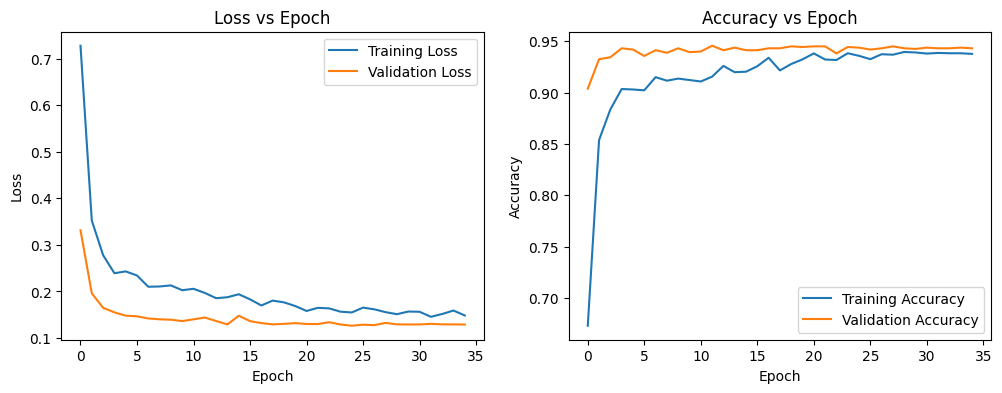

In [167]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_class.history['loss'], label='Training Loss')
plt.plot(history_class.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_class.history['accuracy'], label='Training Accuracy')
plt.plot(history_class.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()